## 1. $H\rightarrow b\bar{b}$ via Machine Learning

Machine learning algorithms are one of the ways with which we create Artificial Intelligence. The distinguishing featuere of machine learning compared to usual programming is training. Instead of programming the steps to get to the solution to a problem we program a machine learning algorithm to be trained to learn the steps towards the desired solution. 

On the ATLAS $H\rightarrow b\bar{b}$ analysis, using a BDT allows us to extract information about the correlations between the different kinematic and topolical variables to improve discrimination between signal and background. 

In this exercise you will use a Boosted Decision Tree algorithm to classify $H\rightarrow b\bar{b}$ events instead of sequential cuts. 

### 1.1 What is a Boosted Decision Tree?

The Boosted Decision Tree algorithm has been very successful at making classifications in particle physics problems. It works by building a *forest* of _decision trees_ where each decision tree consists of a set of binary decisions that lead to classification. A weighted average of the classifications is then taken to give a final BDT output decision score. 


![BDT](images/bdt.png)



### 1.2 Using BDTs

The algorithm for doing the $H\rightarrow b\bar{b}$ can be summarised with the following 6 steps:

* Import scikit-learn library and load data.
* Training BDTs using supervised learning. 
* Score events using the BDT. 
* Calculate sensitivity. 


### Importing libraries and loading 

We will be using the scikit-learn python library which has an implementation of the AdaBoost classifier that is commonly used in the ATLAS analysis. 


In the code below we first import the AdaBoost Classifier and then import the data.

In [4]:
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
from copy import deepcopy
from ucl_masterclass import *
from sklearn.tree import DecisionTreeClassifier


df_even= pd.read_csv('../data-v1/VHbb_data_2jet_even.csv')
df_odd = pd.read_csv('../data-v1/VHbb_data_2jet_odd.csv')



### Training 

You may have wondered why the above data is loaded into two data frames labelled odd and even. We do this to avoid *overtraining*. But before we go into that, let's cover the basics of training. 

The BDT is given a set of training events that have a Class label of 1 for signal and 0 for background. During the training phase, the BDT's goal is to *learn* how to map input variables given to it (kinematic and topological quantities of the event) to 0 for background and 1 for signal. 

To ensure that the BDT is learning general features about the signal and background process and not just **artifacts** unique to the training data set, we split the data set into a training and validation set. Two BDTs are trained with one being trained on *even* events and tested on *odd* events and the other being trained on *odd* events and tested on *even* events.

**In the section below we extract the input (x) and target values (y) used to train the BDT.**

In [5]:
# List of variables used in training

variables = ['dRBB','mBB',
                     'pTB1', 'pTB2', 'MET',
                     'dPhiVBB','dPhiLBmin','Mtop',
                     'dYWH', 'mTW', 'pTV',]

# Even events

x_even = df_even[variables].as_matrix()
y_even = df_even['Class'].as_matrix()
w_even = df_even['training_weight'].as_matrix()

# Odd events

x_odd = df_odd[variables].as_matrix()
y_odd = df_odd['Class'].as_matrix()
w_odd = df_odd['training_weight'].as_matrix()


### Create BDTs

In the code cell below we will be creating two BDTs from the AdaBoost class of algorithms. Documentation for the AdaBoostClassifier can be found here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html.

We will be selecting the parameters to design our BDT classifier. The parameters we will be changing are:

* Number of estimators: this is the number of trees used in the BDT. Although one may think a large number of trees will lead to an excellent classifier this is not generally the case. Once a BDT converges to the solution, adding more trees does not provide much inrease in performance but does increase the computation time. 
* Tree depth: this is the number of binary decisions within the individual decision trees. Deep trees can lead to good classifiers but is likely to lead to overfitting. This means the classifier learns features that are specific to the training examples rather than general features of the solution. 
* Learning Rate: this is step size when updating the weights to minimise the gradient. 

If the above parameters do not make sense, please feel free to ask your mentor! 


In [6]:
n_estimators = 100
max_depth = 4
learning_rate = 0.15

# Add parameter arguments below
bdt_even = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=0.01),
                                          learning_rate=learning_rate,
                                          n_estimators=n_estimators
                                          )

bdt_odd = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=0.01),
                                         learning_rate=learning_rate,
                                         n_estimators=n_estimators
                                         )

### Fitting to Data

Add the arguments to the fit function for both BDTs. Remember to train one BDT on the even data set and one on the odd data set. 

In [7]:
bdt_even.fit(X= x_even,y = y_even ,sample_weight = w_even)
print("training")

bdt_odd.fit(X= x_odd ,y = y_odd ,sample_weight = w_odd)
print("training")


training
training


## Scoring events


The decision_function returns a score for a given input variable (event). The code below illustrates how to use the function. In the code cell below: 

    bdt_even.decision_function(input_variables).tolist()

Use the decision function to score events and save them to the pandas df. Make sure the BDT isn't scoring the same events it was trained on! 


In [8]:
# Complete code below

df_even['decision_value'] = bdt_odd.decision_function(x_even).tolist() 
df_odd['decision_value'] = bdt_even.decision_function(x_odd).tolist()

print("done")


done


/Users/ishankhurana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/Users/ishankhurana/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:2096: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


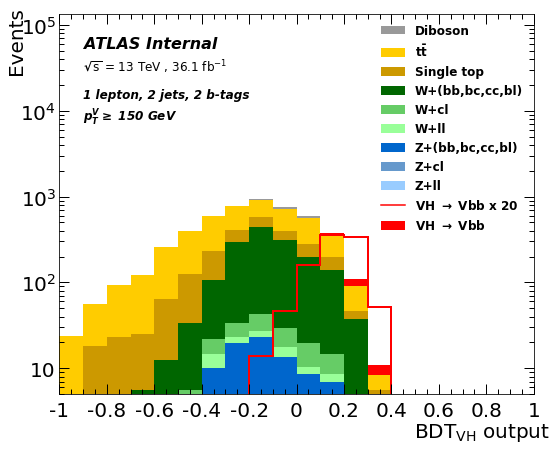

inf


/Users/ishankhurana/Documents/hackingEducation/in2HEP/notebooks/ucl_masterclass.py:524: RuntimeWarning: divide by zero encountered in double_scalars
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


In [9]:
df = pd.concat([df_even,df_odd])

bdt_plot(df)
sensitivity = sensitivity_bdt(df)
print(sensitivity)

** Exercise: Adjust the BDT parameters and see how it affects the sensitivity achieved**

### Exercise 2: In this task we will be studying the effect of sequentially adding variables to the BDT and seeing how it improves sensitivity.

* Add variables to the variables list and train a BDT. 
* Note down the sensitivity achieved and the variables used. 
* In the next section you will plot the increase in sensitivity as variables are added. 

In [19]:
# List of variables used in training

all_variables = ['dRBB','mBB',
                     'pTB1', 'pTB2', 'MET',
                     'dPhiVBB','dPhiLBmin','Mtop',
                     'dYWH', 'mTW', 'pTV',]

variables = ['mBB']

# Even events

x_even = df_even[variables].as_matrix()
y_even = df_even['Class'].as_matrix()
w_even = df_even['training_weight'].as_matrix()

# Odd events

x_odd = df_odd[variables].as_matrix()
y_odd = df_odd['Class'].as_matrix()
w_odd = df_odd['training_weight'].as_matrix()

n_estimators = 200
max_depth = 4
learning_rate = 0.15

# Add parameter arguments below
bdt_even = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=0.01),
                                          learning_rate=learning_rate,
                                          n_estimators=n_estimators
                                          )

bdt_odd = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=0.01),
                                         learning_rate=0.15,
                                         n_estimators=n_estimators
                                         )


bdt_even.fit(X= x_even ,y = y_even ,sample_weight = w_odd)

bdt_odd.fit(X= x_odd,y = y_odd ,sample_weight = w_odd)


# Complete code below using the decision_function method

df_even['decision_value'] = 
df_odd['decision_value'] = 

df = pd.concat([df_even,df_odd])

bdt_plot(df)
sensitivity = sensitivity_bdt(df)
print(sensitivity)

SyntaxError: invalid syntax (<ipython-input-19-62255d84226d>, line 45)

In [ ]:
## Plotting sensitivity graph

# Add the sensitivities you noted down to the list
sensitivities = []

# Add variable names to the list below. Make sure you keep the same order
variable_names = []

num_variables_used = len(sensitivities)



fig = plt.figure()
fig.set_size_inches(8.5,7)
x = list(np.arange(0,num_variables_used,1))
plt.plot(x,sensitivities,'o')
plt.xlim(-1,9)
plt.ylim(1,3)
plt.xticks(x, variable_names);

plt.xlabel('Variables')
plt.ylabel('Sensitivity')


# Once you have finalised your plots you can export a .png file by uncommenting the code below

#plt.savefig('cut_based_variable_comparison.png')

## Summary 

BDTs can learn correlations between variables and create a better understanding of the classification process hence leading to better signal sensitivity. They have been very popular on ATLAS and regularly win competitions on the Kaggle machine learning forum. If you are interested in doing more machine learning here are a list of online resources you may find useful: 

* This is a free 'nanodegree' on deep learning: https://www.youtube.com/watch?v=vOppzHpvTiQ&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3